Using the cluster_feats saved in each country's results folder, we will finally predict the metric of interest (consumption per capita). There are many ways to evaluate our results, I do the following: <br>
1) randomized CV - use 5-fold cross validation randomly on all clusters, all countries <br>
2) randomized CV per country - use 5-fold cross validation within a country for all countries <br>
3) spatial CV per country - use 5-fold cross validation but folds consist of clusters that are geographically close <br>
4) cross-country CV - we have three countries, so hold one country out and perform cross validation <br>

Jean et al use the 2nd evaluation method. One important point: in their code, they use pearson R and square it to get R^2. The more conventional way is shown here: https://en.wikipedia.org/wiki/Coefficient_of_determination. I use the latter method, as in my experience this is standard for reporting R^2. Jean et al's method will likely lead to a higher "R^2" than the conventional method, and doing so prevents a negative R^2 whereas the conventional method allows that possibility.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import geopandas as gpd

import json
from shapely.geometry import shape, Point

%matplotlib inline

In [2]:
BASE_DIR = '..'

RANDOM_SEED = 7 # for reproducibility
COUNTRIES_DIR = os.path.join(BASE_DIR, 'data', 'countries')
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

In [3]:
import sys
sys.path.append(BASE_DIR)
from utils import merge_on_lat_lon, assign_groups, run_randomized_cv, run_spatial_cv



# Predict Consumption

In [22]:
def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''

    country_processed_dir = os.path.join(COUNTRIES_DIR, country, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'clusters.csv'))
    
    print(df_clusters)
    print(cluster_list)
    print(x)

    
#     # ---WARNING--- HARDCODED DELETION 
#     if country == 'malawi_2016':
#         cluster_list.drop(cluster_list.tail(70).index, inplace = True)
#         x = x[:-70, :]
    if country == 'ethiopia_2015':
        df_clusters.drop(df_clusters.tail(24).index, inplace = True)
        cluster_list.drop(cluster_list.tail(0).index, inplace = True)
#         x = x[:-77, :]
#     elif country == 'nigeria_2015':
#         cluster_list.drop(cluster_list.tail(66).index, inplace = True)
#         x = x[:-66, :]


    print(df_clusters)
    print(cluster_list)
    print(x)

    assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
    assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [23]:
x_eth, df_eth = load_country('ethiopia_2015')

    country  cluster_lat  cluster_lon    cons_pc      temp
0       eth     3.455701    39.515994  14.854634  2.010416
1       eth     3.549937    39.184234  14.312022  2.177776
2       eth     3.864243    39.101366  12.470145  2.333336
3       eth     3.982931    38.491368   8.336539  2.558336
4       eth     4.048194    41.930928   4.762526  1.533333
..      ...          ...          ...        ...       ...
518     eth    14.288590    38.210252  13.926005  2.048437
519     eth    14.300796    39.059489   6.882396  1.906946
520     eth    14.319217    39.271599   5.894326  1.822571
521     eth    14.353816    37.890876   8.197660  2.131252
522     eth    14.455962    39.479082  11.191210  1.849306

[523 rows x 5 columns]
     cluster_lat  cluster_lon  feat_index
0       3.455701    39.515994           0
1       3.549937    39.184234           1
2       3.864243    39.101366           2
3       3.982931    38.491368           3
4       4.048194    41.930928           4
..           ...

In [24]:
y_eth = df_eth['cons_pc'].values

In [25]:
print(df_eth)

    country  cluster_lat  cluster_lon    cons_pc      temp  feat_index
0       eth     3.455701    39.515994  14.854634  2.010416           0
1       eth     3.549937    39.184234  14.312022  2.177776           1
2       eth     3.864243    39.101366  12.470145  2.333336           2
3       eth     3.982931    38.491368   8.336539  2.558336           3
4       eth     4.048194    41.930928   4.762526  1.533333           4
..      ...          ...          ...        ...       ...         ...
494     eth    13.842604    39.719644  11.716010  1.754164         494
495     eth    13.844084    38.480325   3.507493  2.043747         495
496     eth    13.871339    38.636691   8.485883  2.018749         496
497     eth    13.895388    39.787300  16.240493  1.770136         497
498     eth    13.984371    39.533129   7.824775  1.799999         498

[499 rows x 6 columns]


In [34]:
def test_fully_randomized_cv():
    print("Testing fully randomized CV:\n--------------\n")
    x_all = np.concatenate([x_eth], axis=0)
    y_all = np.concatenate([y_eth], axis=0)
    r2_direct, _ = run_randomized_cv(x_all, y_all, random_seed=RANDOM_SEED, to_print=False)
    r2_log, _ = run_randomized_cv(x_all, np.log(y_all), random_seed=RANDOM_SEED)
    print(f"For fully randomized cv: direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_randomized_cv_per_country():
    print("Testing per country randomized CV:\n--------------\n")
    xs = [x_eth]
    ys = [y_eth]
    countries = ['ethiopia_2015']
    for x, y, c in zip(xs, ys, countries):
        r2_direct, _ = run_randomized_cv(x, y, random_seed=RANDOM_SEED, to_print=False)
        r2_log, _ = run_randomized_cv(x, np.log(y), random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_spatial_cv_per_country():
    print("Testing per country spatial CV:\n--------------\n")
    xs = [x_eth]
    ys = [y_eth]
    dfs = [df_eth]
    countries = ['ethiopia_2015']
    for x, y, df, c in zip(xs, ys, dfs, countries):
        groups, _ = assign_groups(df, k=5, random_seed=RANDOM_SEED)
        r2_direct, _ = run_spatial_cv(x, y, groups, random_seed=RANDOM_SEED)
        r2_log, _ = run_spatial_cv(x, np.log(y), groups, random_seed=RANDOM_SEED)
        print(f"For {c}, direct r2: {r2_direct}, log r2: {r2_log}")

In [35]:
# this concatenates all countries and runs randomized CV
test_fully_randomized_cv()

Testing fully randomized CV:
--------------

For fully randomized cv: direct r2: 0.19980808696001098, log r2: 0.21351316953546512


In [36]:
# this runs randomized CV per country; this is how Jean et al report their results
# we can see that the model does perform well, although how well it performs varies greatly
# in our three countries. It is difficult to make statements about why the model 
# does better in certain countries (and why predicting the log doesn't do better in ethiopia)
# without more analysis and more countries
test_randomized_cv_per_country()

Testing per country randomized CV:
--------------

For ethiopia_2015, direct r2: 0.19980808696001098, log r2: 0.21351316953546512


In [37]:
# spatial CV provides very inconsistent results. this indicates that the model is 
# greatly advantaged in randomized CV, most likely because it can train on one cluster and 
# validate on a nearby cluster. this suggests there is still more to be desired for a truly generalizable model
test_spatial_cv_per_country()

Testing per country spatial CV:
--------------

For ethiopia_2015, direct r2: 0.05086980746268015, log r2: -0.046824410183840315


# Plots

In [28]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6)
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='red')
    plt.text(23, 21, f'r^2={round(r2, 2)}', size=12)
    plt.xlabel('Actual Consumption per Capita ($/day)', fontsize=15)
    plt.ylabel('Predicted Consumption per Capita ($/day)', fontsize=15)
    plt.title(f'{country} Cross Validation Results', fontsize=20)
    return fig

In [29]:
r2, yhat_eth = run_randomized_cv(x_eth, y_eth, random_seed=RANDOM_SEED, to_print=False)

In [30]:
df_eth['cons_pc_pred'] = yhat_eth

In [31]:
def graph_consumption(geojson_file, consumption_type):
    map_gpd = gpd.read_file(geojson_file)
    
    with open(geojson_file) as f:
        js = json.load(f)
    
    map_df = pd.DataFrame(map_gpd['name_2'])
    map_df[consumption_type] = 0 
    
    for index, row in df_eth.iterrows():
        cord_lon = row['cluster_lon']
        cord_lat = row['cluster_lat']
        cons_pc = row[consumption_type]
        point = Point(cord_lon, cord_lat)
        for feature in js['features']:
            polygon = shape(feature['geometry'])
            if polygon.contains(point):
                zone = feature['properties']['name_2']
                df_loc = map_df.loc[map_df['name_2'] == zone]
                map_df.loc[df_loc.index, consumption_type] += cons_pc
                
    merged = map_df.merge(map_gpd, how='left', on="name_2")
    merged = merged[['name_2', 'geometry', consumption_type]]
    merged = gpd.GeoDataFrame(merged)
    
    
    # set the value column that will be visualised
    variable = consumption_type
    # set the range for the choropleth values
    vmin, vmax = 0, 1
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10))
    # remove the axis
    ax.axis('off')
    # add a title and annotation
    if consumption_type == "cons_pc":
        ax.set_title('Actual Consumption per Capita for each Zone', fontdict={'fontsize': '25', 'fontweight' : '3'})
    else:
        ax.set_title('Predicted Consumption per Capita for each Zone', fontdict={'fontsize': '25', 'fontweight' : '3'}) 
        
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    cbar = fig.colorbar(sm)
    cbar.ax.tick_params(labelsize=20)
    # create map
    merged.plot(column=variable, cmap='Blues', linewidth=1, ax=ax, edgecolor='black')

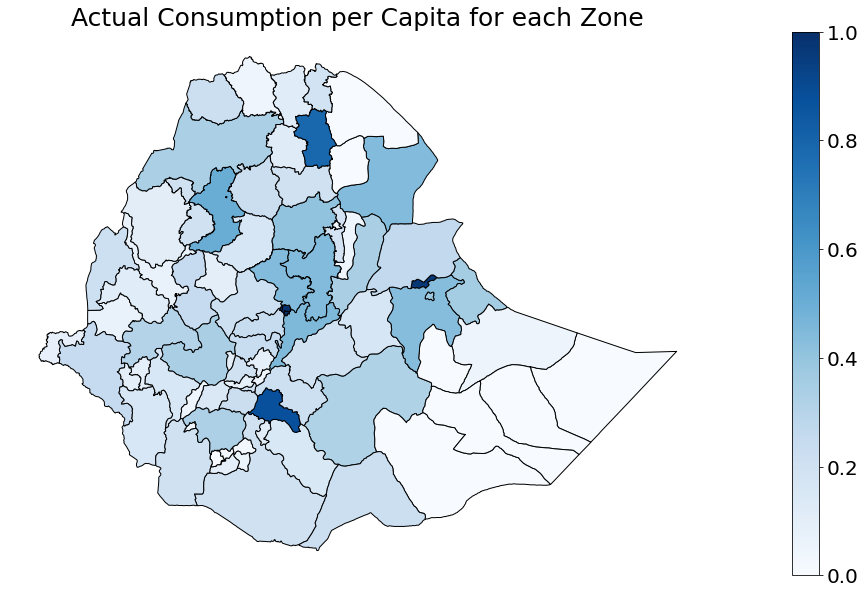

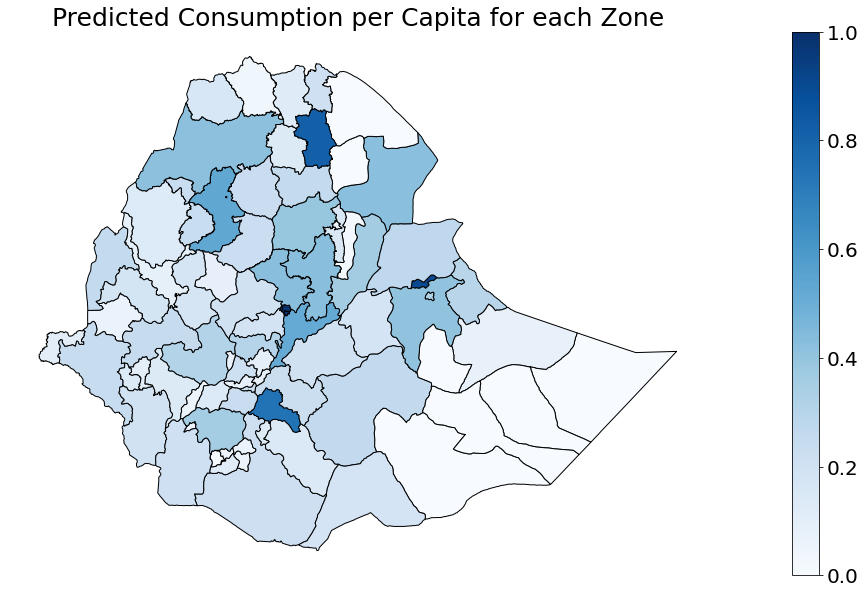

In [32]:
geojson_file = '../data/countries/ethiopia_2015/shp/eth_geojson.json'

graph_consumption(geojson_file, "cons_pc")
graph_consumption(geojson_file, "cons_pc_pred")

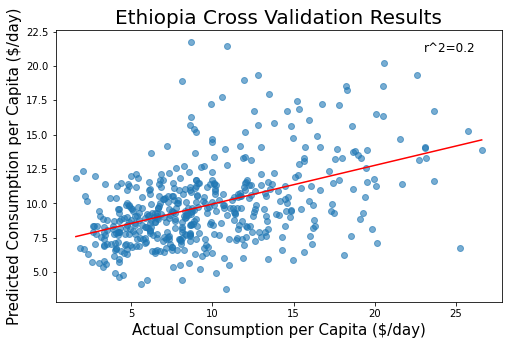

In [33]:
fig = plot_predictions(y_eth, yhat_eth, r2, 'Ethiopia', max_y=30)

In [ ]:
fig.savefig(os.path.join(FIGURES_DIR, 'ethiopia_results.png'))